In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from glob import glob
import os
import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil

In [6]:
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

In [10]:
positive_data_info = pd.read_excel(r'/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx')
positive_data_info.head()

,FILE NAME,FORMAT,SIZE,URL
0,Tuberculosis-1,PNG,512*512,http://tuberculosis.by/
1,Tuberculosis-2,PNG,512*512,http://tuberculosis.by/
2,Tuberculosis-3,PNG,512*512,http://tuberculosis.by/
3,Tuberculosis-4,PNG,512*512,http://tuberculosis.by/
4,Tuberculosis-5,PNG,512*512,http://tuberculosis.by/


In [11]:
negative_data_info = pd.read_excel(r'/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx')
negative_data_info.head()

,FILE NAME,FORMAT,SIZE,URL
0,Normal-1,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1,Normal-2,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
2,Normal-3,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
3,Normal-4,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
4,Normal-5,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...


In [12]:
positive_data_info['labels'] = 'positive'
negative_data_info['labels'] = 'negative'

In [13]:
datainfo = pd.concat([negative_data_info,positive_data_info]).drop_duplicates().reset_index(drop=True)
datainfo.head()

,FILE NAME,FORMAT,SIZE,URL,labels
0,Normal-1,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,negative
1,Normal-2,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,negative
2,Normal-3,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,negative
3,Normal-4,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,negative
4,Normal-5,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,negative


In [14]:
datainfo['image_id'] = datainfo['FILE NAME'] + "." + datainfo['FORMAT'].str.lower()
datainfo = datainfo.drop(columns= ['FORMAT','FILE NAME','URL'])
datainfo.head()

,SIZE,labels,image_id
0,512*512,negative,Normal-1.png
1,512*512,negative,Normal-2.png
2,512*512,negative,Normal-3.png
3,512*512,negative,Normal-4.png
4,512*512,negative,Normal-5.png


In [15]:
le = LabelEncoder()
datainfo['labels'] = le.fit_transform(datainfo['labels'])

In [16]:
datainfo['labels'].value_counts()

0    3500
1     700
Name: labels, dtype: int64

In [18]:
def show_data(path):
    images = os.listdir(path)
    rows = 4
    columns = 10
    fig = plt.figure(figsize=(20, 10)) 
    for i in range(40):
        IMAGEI_PATH = os.path.join(path,images[i])
        img = cv2.imread(IMAGEI_PATH)
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img[...,::-1],cmap='gray')  # Converts bgr to rgb
        plt.title(images[i].split('-')[0])   

In [25]:
positive_images_path = r'/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis'
normal_images_path = r'/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal'

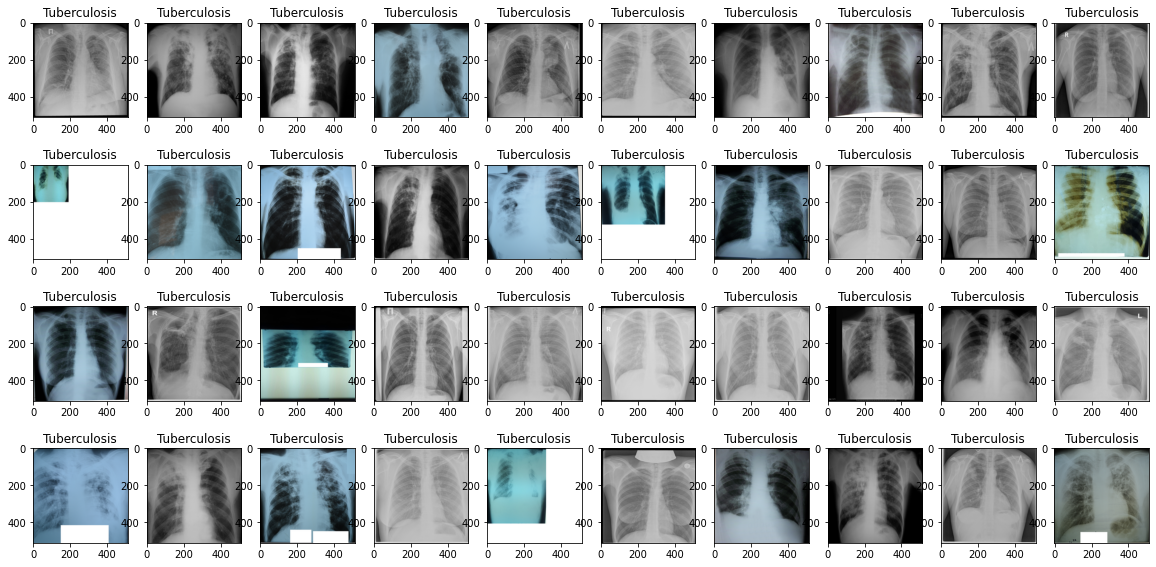

In [26]:
show_data(positive_images_path)

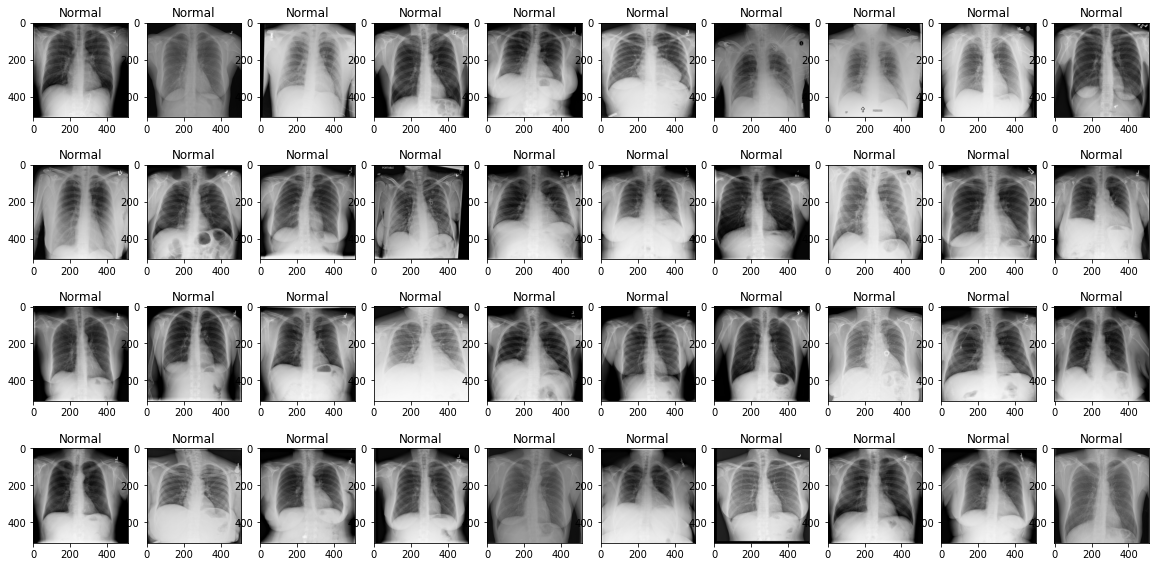

In [27]:
show_data(normal_images_path)

In [28]:
y = datainfo['labels']

df_train, df_val = train_test_split(datainfo, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(3570, 3)
(630, 3)


In [29]:
dataset_dir = 'dataset'

# Creating the train and test dataset directories
if(not os.path.exists(dataset_dir)):
    os.mkdir(dataset_dir)
    train_dir = os.path.join(dataset_dir, 'train')
    os.mkdir(train_dir)
    
    val_dir = os.path.join(dataset_dir, 'val')
    os.mkdir(val_dir)

    Normal = os.path.join(train_dir, 'Normal')
    os.mkdir(Normal)
    Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
    os.mkdir(Tuberculosis)

    Normal = os.path.join(val_dir, 'Normal')
    os.mkdir(Normal)
    Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
    os.mkdir(Tuberculosis)

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')

In [31]:
import shutil
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Copying the data from the original dataset 
# to the newly created train and test directories
for image in train_list:
    label= int(datainfo.loc[datainfo['image_id'] == image,'labels'])
    fname = image
    # print(int(label))
    if label == 0:
        src = os.path.join(normal_images_path,image)
        dst = os.path.join(train_dir,'Normal',fname)
        img = cv2.imread(src)
        cv2.resize(img,[IMAGE_HEIGHT,IMAGE_WIDTH])
        cv2.imwrite(dst,img)
        # shutil.copy(src,dst)
    if label == 1:
        src = os.path.join(positive_images_path,image)
        dst = os.path.join(train_dir,'Tuberculosis',fname)
        img = cv2.imread(src)
        cv2.resize(img,[IMAGE_HEIGHT,IMAGE_WIDTH])
        cv2.imwrite(dst,img)
        # shutil.copy(src,dst)

for image in val_list:
    label= int(datainfo.loc[datainfo['image_id'] == image,'labels'])
    fname = image
    if label == 0:
        src = os.path.join(normal_images_path,image)
        dst = os.path.join(val_dir,'Normal',fname)
        img = cv2.imread(src)
        cv2.resize(img,[IMAGE_HEIGHT,IMAGE_WIDTH])
        cv2.imwrite(dst,img)
        # shutil.copy(src,dst)
    if label == 1:
        src = os.path.join(positive_images_path,image)
        dst = os.path.join(val_dir,'Tuberculosis',fname)
        img = cv2.imread(src)
        cv2.resize(img,[IMAGE_HEIGHT,IMAGE_WIDTH])
        cv2.imwrite(dst,img)
        # shutil.copy(src,dst)      

In [32]:
print(len(os.listdir(os.path.join(train_dir,'Normal'))))
print(len(os.listdir(os.path.join(train_dir,'Tuberculosis'))))
print('\n')
print(len(os.listdir(os.path.join(val_dir,'Normal'))))
print(len(os.listdir(os.path.join(val_dir,'Tuberculosis'))))

2975
595


525
105


In [34]:
class_list = ['Normal','Tuberculosis']
for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later.
    # create a base dir
    aug_dir = 'dataset/aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_path = os.path.join(train_dir, img_class)
    img_list = os.listdir(img_path)

    # Copy images from the class train dir to the img_dir e.g. class 'Normal'
    for fname in img_list:
            # source path to image
            src = os.path.join(img_path, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = os.path.join(train_dir,img_class)

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='png',
                                                    target_size=(512,512),
                                                    batch_size=batch_size)
    
    
    # Generate the augmented images and add them to the training folders
    
    
    num_files = len(os.listdir(img_dir))
    
    # this creates a similar amount of images for each class
    num_batches = int(np.ceil((1000-num_files)/batch_size))

    # run the generator and create augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree(aug_dir)

Found 2975 images belonging to 1 classes.
Found 595 images belonging to 1 classes.


In [35]:
print(len(os.listdir(os.path.join(train_dir,'Normal'))))
print(len(os.listdir(os.path.join(train_dir,'Tuberculosis'))))
print('\n')
print(len(os.listdir(os.path.join(val_dir,'Normal'))))
print(len(os.listdir(os.path.join(val_dir,'Tuberculosis'))))

2975
1045


525
105


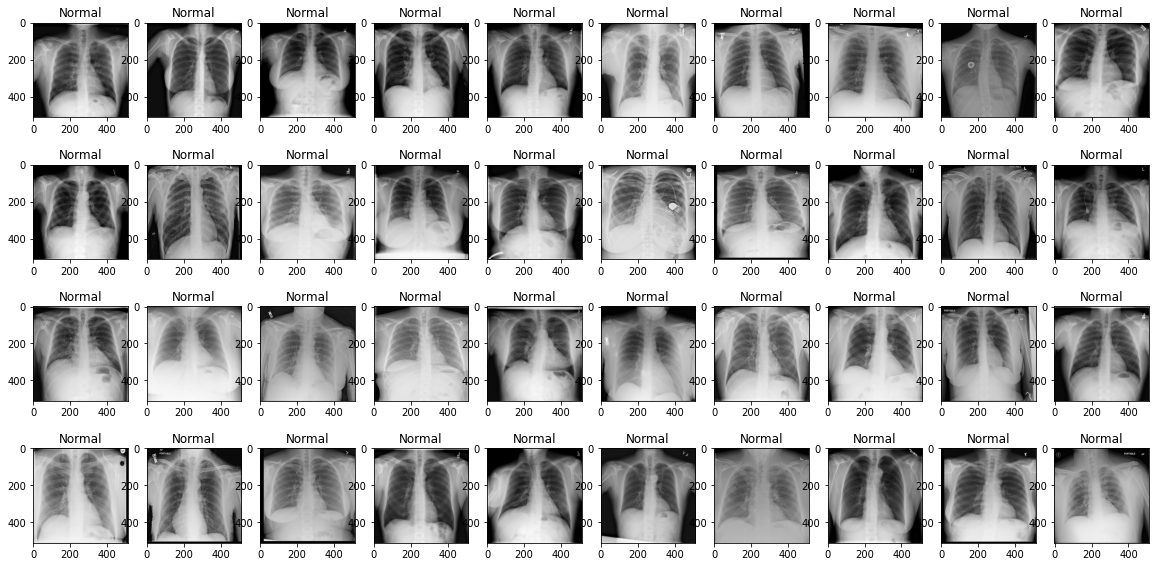

In [36]:
show_data(os.path.join(train_dir,'Normal'))

In [37]:
len(df_train)

3570

In [38]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 40
val_batch_size = 40


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [39]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_dir,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(val_dir,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(val_dir,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)


Found 4020 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
Found 630 images belonging to 2 classes.


In [40]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        3

2022-12-20 07:56:36.320020: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [41]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [42]:
filepath = "archive/dataset/model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_learning_rate=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

In [43]:
history = model.fit(train_gen, steps_per_epoch=train_steps, 
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=100,
                           callbacks=callbacks_list)

2022-12-20 07:57:16.101735: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
90/90 [==============================] - 106s 1s/step - loss: 0.5435 - accuracy: 0.7422 - val_loss: 0.3441 - val_accuracy: 0.9127
Epoch 2/100
90/90 [==============================] - 107s 1s/step - loss: 0.3440 - accuracy: 0.8594 - val_loss: 0.2388 - val_accuracy: 0.9238
Epoch 3/100
90/90 [==============================] - 107s 1s/step - loss: 0.2391 - accuracy: 0.9109 - val_loss: 0.1720 - val_accuracy: 0.9381
Epoch 4/100
90/90 [==============================] - 105s 1s/step - loss: 0.2155 - accuracy: 0.9182 - val_loss: 0.1464 - val_accuracy: 0.9397
Epoch 5/100
90/90 [==============================] - 107s 1s/step - loss: 0.1973 - accuracy: 0.9229 - val_loss: 0.1552 - val_accuracy: 0.9460
Epoch 6/100
90/90 [==============================] - 104s 1s/step - loss: 0.1883 - accuracy: 0.9316 - val_loss: 0.1875 - val_accuracy: 0.9381
Epoch 7/100
90/90 [==============================] - 104s 1s/step - loss: 0.1827 - accuracy: 0.9310 - val_loss: 0.1388 - val_accuracy: 0.9429
Epoch 

<Figure size 432x288 with 0 Axes>

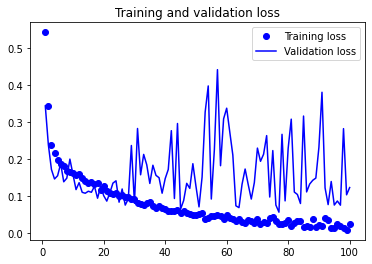

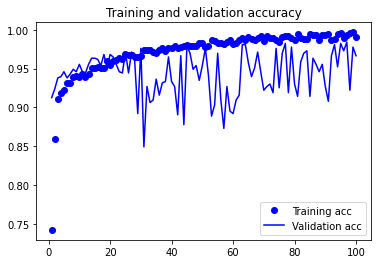

<Figure size 432x288 with 0 Axes>

In [60]:

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [44]:
test_labels = test_gen.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [45]:
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [46]:
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


16/16 [==============================] - 7s 432ms/step


In [47]:
predictions.shape

(630, 2)

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [51]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[508  17]
 [  4 101]]


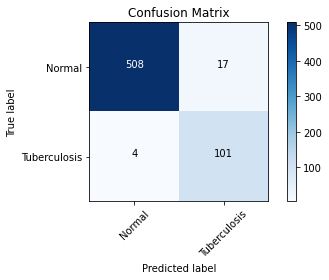

In [52]:
cm_plot_labels = ['Normal', 'Tuberculosis']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [53]:
from sklearn.metrics import classification_report

# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       525
Tuberculosis       0.86      0.96      0.91       105

    accuracy                           0.97       630
   macro avg       0.92      0.96      0.94       630
weighted avg       0.97      0.97      0.97       630



In [63]:
!pip install pyyaml h5py  # Required to save models in HDF5 format


In [75]:
model.save('model.h5')

In [76]:
from IPython.display import FileLink
FileLink(r'model.h5')

/kaggle/working/model.h5

In [4]:
model = tf.keras.models.load_model('model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

In [20]:
from tensorflow.keras.preprocessing.image import load_img, array_to_img

img = load_img(r"D:\Python projects\ML-projects\TB-Detection\archive\dataset\val\Normal\Normal-3489.png")
img = tf.convert_to_tensor(np.asarray(img))
image = tf.image.resize(img, [96, 96])
# image_resized = tf.reshape(image, (-1, 96, 96, 3, 1))
# image_resized = tf.squeeze(image_resized)
# image_resized.shape
image = tf.expand_dims(image,axis=0)
image.shape
model.predict(image_resized)

ValueError: in user code:

    File "c:\Users\Vanshaj\.conda\envs\tensorflowenv_20220122\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Vanshaj\.conda\envs\tensorflowenv_20220122\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Vanshaj\.conda\envs\tensorflowenv_20220122\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Vanshaj\.conda\envs\tensorflowenv_20220122\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\Users\Vanshaj\.conda\envs\tensorflowenv_20220122\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Vanshaj\.conda\envs\tensorflowenv_20220122\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 96, 96, 3), found shape=(32, 96, 3)
